# Scaling data using the area of geometry

* The idea is to find a way to normalize the street pole count and the crime stats according to the size (area) of the neighborhood/PPD precinct used to group your data

* In GeoPandas you can change CRS using projection and looking around it is suggested that the EPSG4326 coordinates in the neighborhood GeoJSON is in degrees and needs to be projected to a CRS that is a flat projection in meters. I think the following does this correctly.

* Then once you have the area in square miles (for instance - although the units don't actually matter aside from ease of interpretation) you can divide street pole count in an polygon by this figure.

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
neighborhood_gdf = gpd.read_file('../data/gn-philadelphia.geojson')

* What CRS is this in?

In [3]:
neighborhood_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [4]:
neighborhood_gdf.crs.axis_info

[Axis(name=Geodetic latitude, abbrev=Lat, direction=north, unit_auth_code=EPSG, unit_code=9122, unit_name=degree),
 Axis(name=Geodetic longitude, abbrev=Lon, direction=east, unit_auth_code=EPSG, unit_code=9122, unit_name=degree)]

* This CRS has degrees angles as units so can't calculate the area accurately 

* Project to a CRS with meters as unit

In [5]:
# "+proj=eck4 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs"
# see https://gis.stackexchange.com/questions/285266/geopandas-proj4-reproject-to-global-equal-area-projection
# for source of this code

neighborhood_gdf.to_crs("+proj=eck4 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs").crs.axis_info

[Axis(name=Easting, abbrev=E, direction=east, unit_auth_code=EPSG, unit_code=9001, unit_name=metre),
 Axis(name=Northing, abbrev=N, direction=north, unit_auth_code=EPSG, unit_code=9001, unit_name=metre)]

* Project to this CRS and add `area` as a new column

In [6]:
neighborhood_gdf['area']=neighborhood_gdf.to_crs("+proj=eck4 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs").area.apply(lambda x: (x/10e5)/1.6)

* Lets plot this to verify that it looks reasonable

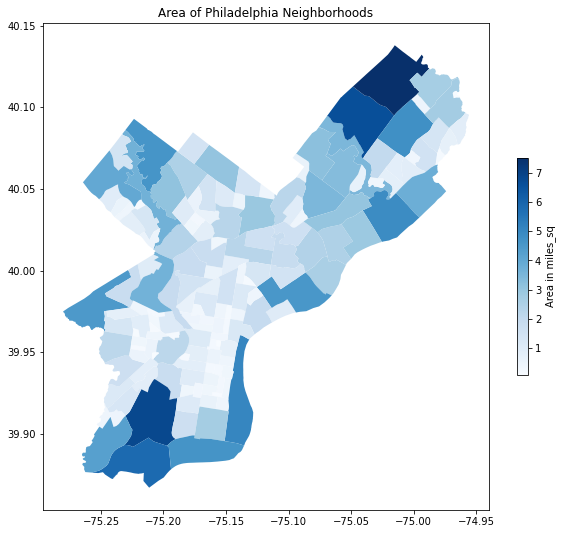

In [7]:
neighborhood_gdf.plot(figsize=(10,10), column='area', 
                      legend=True, 
                      legend_kwds = { 'shrink': 0.4,
                                     'label': 'Area in miles_sq'},
                      cmap='Blues')
plt.title('Area of Philadelphia Neighborhoods')
plt.show()


In [8]:
neighborhood_gdf[['name','area']].query("name.str.contains('City')").set_index('name') 

,area
name,
Old City,0.729857
Center City East,0.238273
University City,2.193376


* I think these look reasonable from what I can tell searching for sq/mile areas of parts of Philly

### Now add in the street pole data

* Taking the code from your analysis notebook

In [9]:
spoles_gdf = gpd.read_file('../data/Street_Poles.geojson')

In [10]:
spn_gdf = gpd.sjoin(spoles_gdf, neighborhood_gdf, op='within')


In [11]:
spn_gdf.shape

(195089, 31)

In [12]:
sp_neighborhood_counts = spn_gdf.groupby(['name','area']).size().reset_index(name='streetpole_count')


#### Density

* Divide `streetpole_count` by `area` to get the density of street poles per square mile

In [13]:
sp_neighborhood_counts=sp_neighborhood_counts.assign(density=sp_neighborhood_counts['streetpole_count']/sp_neighborhood_counts['area'])

In [14]:
sp_by_nhood_gdf=gpd.GeoDataFrame(pd.merge(neighborhood_gdf,
          sp_neighborhood_counts.set_index('name')[['streetpole_count','density']],
          left_on='name',
          right_index=True))

#### Plot street poles by count and by density

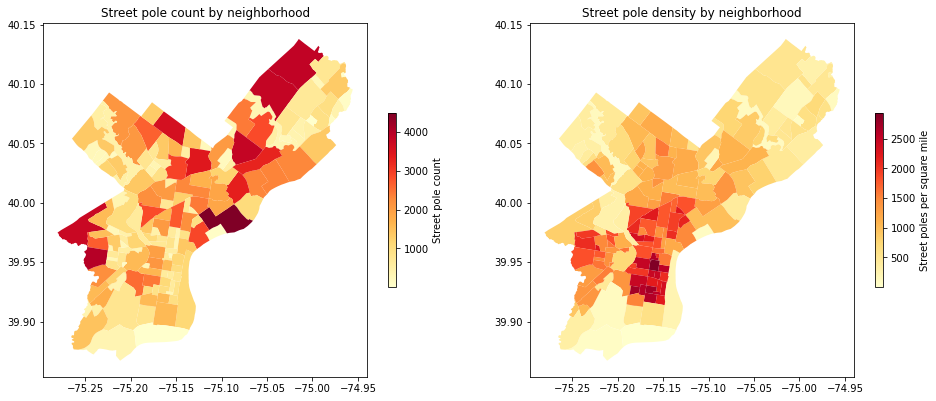

In [15]:
fig, ax = plt.subplots(1,2, figsize=(16,8))

sp_by_nhood_gdf.plot(column='streetpole_count', 
                     figsize=(8,8),
                     cmap='YlOrRd', legend=True,
                     ax=ax[0],
                     legend_kwds = { 'shrink': 0.4,
                                     'label': 'Street pole count'},
                    )

ax[0].set_title('Street pole count by neighborhood')

sp_by_nhood_gdf.plot(column='density', 
                     figsize=(8,8),
                     cmap='YlOrRd', legend=True,
                     ax=ax[1],
                     legend_kwds = { 'shrink': 0.4,
                                     'label': 'Street poles per square mile'},
                    )

ax[1].set_title('Street pole density by neighborhood')

plt.show()

* I think this illustrates the value of using this normalization as the areas in Center City have the highest density of street lights as we'd expect